# AlexNet

In [1]:
#torch
import torch 
import torch.nn as nn
import torch.optim as optim  
import torchvision

import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.datasets import ImageFolder
from torch.utils.data import (
    Dataset,
    DataLoader,
    Subset
) 

# other
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import warnings
from skimage import io
# from PIL import Image
import time

warnings.filterwarnings("ignore")

from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix, compute_accuracy
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import get_dataloaders_cifar10, UnNormalize

from data_loading_functions import split_train_test_loaders, show_img

# Load Data and Preprocessing 

In [2]:
dataset_path = '.\\COVID-19_Radiography_Dataset'
datas, train_loader, valid_loader, test_loader = split_train_test_loaders(dataset_path, 128)

# Display Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train data
actual labels: ['Lung_Opacity', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']
numerical labels: tensor([1, 2, 1, 3])


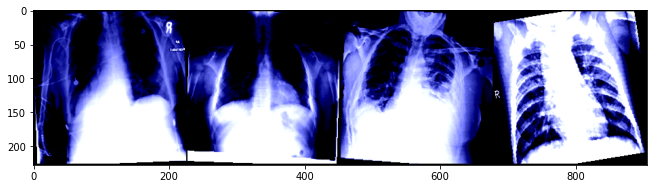

In [3]:
print('train data')
show_img(datas[0])

In [4]:
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break
    
# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([128, 3, 224, 224])
Image label dimensions: torch.Size([128])
tensor([2, 0, 1, 2, 2, 2, 2, 2, 2, 2])

Validation Set:
Image batch dimensions: torch.Size([128, 3, 224, 224])
Image label dimensions: torch.Size([128])
tensor([2, 1, 2, 1, 2, 2, 2, 0, 2, 2])

Testing Set:
Image batch dimensions: torch.Size([128, 3, 224, 224])
Image label dimensions: torch.Size([128])
tensor([1, 2, 2, 1, 2, 1, 1, 1, 2, 2])


In [5]:
print(f'Length of Training: {len(datas[0])}')
print(f'Length of Validation: {len(datas[1])}')
print(f'Length of Testing: {len(datas[2])}')

Length of Training: 16932
Length of Validation: 2117
Length of Testing: 2116


# AlexNet

## Settings

In [6]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0005
BATCH_SIZE = 128
NUM_EPOCHS = 40

# Architecture
NUM_FEATURES = 224*224
NUM_CLASSES = 4

# Other
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GRAYSCALE = False

In [7]:
DEVICE

device(type='cuda')

# Pretrained AlexNet fine tune fc layer + last conv layer

In [8]:
model_ft = torchvision.models.alexnet(pretrained=True)

for name, child in model_ft.named_children():
    if name in ['classifier']:
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

#train last layer
for param in model_ft.features[-1:].parameters():
    param.requires_grad = True

model_ft.classifier[6] = nn.Linear(in_features=4096, out_features=4, bias=True)


torch.manual_seed(RANDOM_SEED)
model_ft.to(DEVICE)

optimizer = torch.optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)  

minibatch_loss_list_ft, train_acc_list_ft, valid_acc_list_ft = train_model(num_epochs = NUM_EPOCHS, model = model_ft, 
                                                                optimizer = optimizer, device = DEVICE, 
                                                                train_loader = train_loader, valid_loader=valid_loader, 
                                                                test_loader = test_loader, logging_interval=50)

Epoch: 001/040 | Batch 0000/0133 | Loss: 1.9859
Epoch: 001/040 | Batch 0050/0133 | Loss: 0.4226
Epoch: 001/040 | Batch 0100/0133 | Loss: 0.3943
Epoch: 001/040 | Train: 84.63% | Validation: 83.28%
Time elapsed: 2.65 min
Epoch: 002/040 | Batch 0000/0133 | Loss: 0.4175
Epoch: 002/040 | Batch 0050/0133 | Loss: 0.4517
Epoch: 002/040 | Batch 0100/0133 | Loss: 0.3682
Epoch: 002/040 | Train: 89.07% | Validation: 87.81%
Time elapsed: 5.28 min
Epoch: 003/040 | Batch 0000/0133 | Loss: 0.3919
Epoch: 003/040 | Batch 0050/0133 | Loss: 0.3287
Epoch: 003/040 | Batch 0100/0133 | Loss: 0.3577
Epoch: 003/040 | Train: 90.49% | Validation: 88.76%
Time elapsed: 7.93 min
Epoch: 004/040 | Batch 0000/0133 | Loss: 0.3253
Epoch: 004/040 | Batch 0050/0133 | Loss: 0.3794
Epoch: 004/040 | Batch 0100/0133 | Loss: 0.3445
Epoch: 004/040 | Train: 90.00% | Validation: 89.23%
Time elapsed: 10.58 min
Epoch: 005/040 | Batch 0000/0133 | Loss: 0.3020
Epoch: 005/040 | Batch 0050/0133 | Loss: 0.3223
Epoch: 005/040 | Batch 0100

# Evaluation AlexNet: fine tuned fc

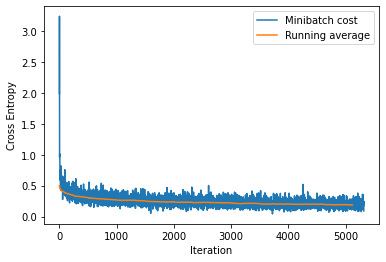

In [9]:
plt.plot(minibatch_loss_list_ft, label='Minibatch cost')
plt.plot(np.convolve(minibatch_loss_list_ft, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

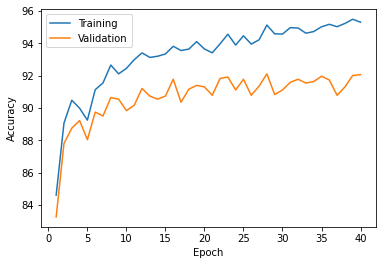

In [10]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list_ft, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list_ft, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

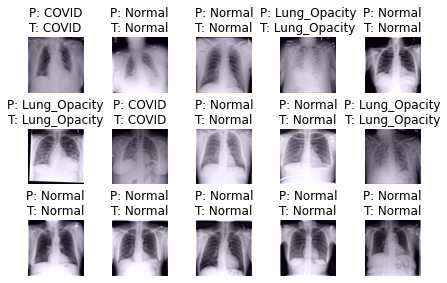

In [12]:
model_ft.cpu()
unnormalizer = UnNormalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.2255))
class_dict  = {0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}

show_examples(model=model_ft, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

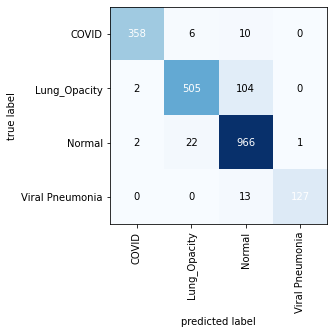

In [13]:
mat = compute_confusion_matrix(model=model_ft, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

# Framework only no Pretrained Alexnet

In [16]:
model_scratch = torchvision.models.alexnet(pretrained=False)

model_scratch.classifier[4] = nn.Linear(in_features=4096, out_features=2048, bias=True)
model_scratch.classifier[6] = nn.Linear(in_features=2048, out_features=4, bias=True)

torch.manual_seed(RANDOM_SEED)
model_scratch.to(DEVICE)

optimizer = torch.optim.Adam(model_scratch.parameters(), lr=LEARNING_RATE)  

minibatch_loss_list_scratch, train_acc_list_scratch, valid_acc_list_scratch = train_model(num_epochs = NUM_EPOCHS, model = model_scratch, 
                                                                optimizer = optimizer, device = DEVICE, 
                                                                train_loader = train_loader, valid_loader=valid_loader, 
                                                                test_loader = test_loader, logging_interval=50)

Epoch: 001/040 | Batch 0000/0133 | Loss: 1.3862
Epoch: 001/040 | Batch 0050/0133 | Loss: 0.9087
Epoch: 001/040 | Batch 0100/0133 | Loss: 0.6911
Epoch: 001/040 | Train: 72.66% | Validation: 70.76%
Time elapsed: 2.42 min
Epoch: 002/040 | Batch 0000/0133 | Loss: 0.6388
Epoch: 002/040 | Batch 0050/0133 | Loss: 0.6776
Epoch: 002/040 | Batch 0100/0133 | Loss: 0.6068
Epoch: 002/040 | Train: 79.38% | Validation: 77.94%
Time elapsed: 4.53 min
Epoch: 003/040 | Batch 0000/0133 | Loss: 0.5414
Epoch: 003/040 | Batch 0050/0133 | Loss: 0.5348
Epoch: 003/040 | Batch 0100/0133 | Loss: 0.5342
Epoch: 003/040 | Train: 81.76% | Validation: 79.50%
Time elapsed: 6.63 min
Epoch: 004/040 | Batch 0000/0133 | Loss: 0.4834
Epoch: 004/040 | Batch 0050/0133 | Loss: 0.4539
Epoch: 004/040 | Batch 0100/0133 | Loss: 0.4952
Epoch: 004/040 | Train: 82.02% | Validation: 80.35%
Time elapsed: 8.78 min
Epoch: 005/040 | Batch 0000/0133 | Loss: 0.5307
Epoch: 005/040 | Batch 0050/0133 | Loss: 0.3770
Epoch: 005/040 | Batch 0100/


# Evaluation

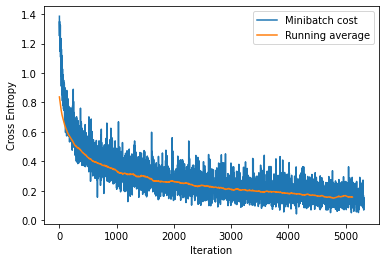

In [17]:
plt.plot(minibatch_loss_list_scratch, label='Minibatch cost')
plt.plot(np.convolve(minibatch_loss_list_scratch, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

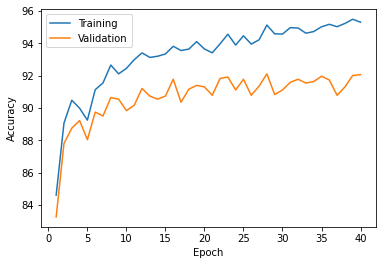

In [18]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list_scratch, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list_scratch, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

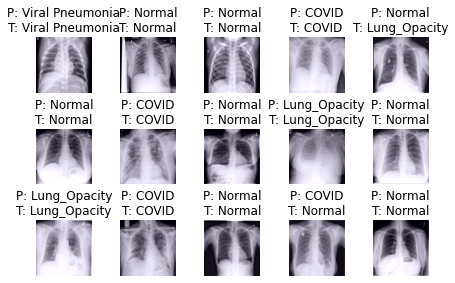

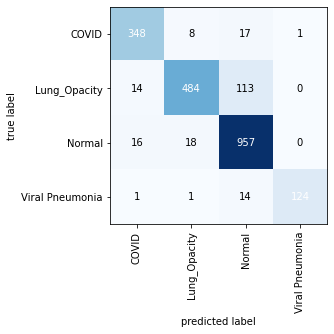

In [20]:
model_scratch.cpu()
unnormalizer = UnNormalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.2255))
class_dict  = {0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}

show_examples(model=model_scratch, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

mat = compute_confusion_matrix(model=model_scratch, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()